In [1]:
"""
Calculate fire season attributes by western U.S. ecoregions
Fire data: Fire Occurrence Dataset (FPA-FOD) 1992-2020
Attributes (by year/ecoregion):
    - Peak season ()
    - Peak season length ()
    - Day of first managed wildfire
    - Day of final wildfire containment

Author: maxwell.cook@colorado.edu
"""

import os, gc
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import mode
from shapely.geometry import Point

import warnings
warnings.filterwarnings("ignore")  # suppresses annoying geopandas warning

proj = 'EPSG:5070'

maindir = '/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/'
projdir = os.path.join(maindir, 'aspen-fire/Aim2/')

print("Ready to go !")

Ready to go !


In [24]:
results_dir = os.path.join(projdir,'data/tabular/mod/FPA-FOD/')
# results_dir = os.path.join(projdir,'results/') # cyverse
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
print(f"Saving outputs to {results_dir}")

Saving outputs to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/FPA-FOD/


In [ ]:
# Load ecoregion and FPA-FOD data and prep for analysis

In [3]:
# Load western U.S. ecoregions
fp = os.path.join(projdir,'data/spatial/mod/boundaries/na_cec_eco_l3_west.gpkg')
ecol3 = gpd.read_file(fp)
ecol3 = ecol3[['NA_L3NAME','geometry']]
ecol3 = ecol3.rename(columns={'NA_L3NAME': 'na_l3name'})
ecol3.columns

Index(['na_l3name', 'geometry'], dtype='object')

In [4]:
# Load the FPA-FOD for the western U.S.
fp = os.path.join(projdir, 'data/spatial/raw/FPA-FOD/fpa-fod_west.gpkg')
fpa_fod = gpd.read_file(fp)
fpa_fod.columns

Index(['OBJECTID', 'FOD_ID', 'FPA_ID', 'SOURCE_SYSTEM_TYPE', 'SOURCE_SYSTEM',
       'NWCG_REPORTING_AGENCY', 'NWCG_REPORTING_UNIT_ID',
       'NWCG_REPORTING_UNIT_NAME', 'SOURCE_REPORTING_UNIT',
       'SOURCE_REPORTING_UNIT_NAME', 'LOCAL_FIRE_REPORT_ID',
       'LOCAL_INCIDENT_ID', 'FIRE_CODE', 'FIRE_NAME',
       'ICS_209_PLUS_INCIDENT_JOIN_ID', 'ICS_209_PLUS_COMPLEX_JOIN_ID',
       'MTBS_ID', 'MTBS_FIRE_NAME', 'COMPLEX_NAME', 'FIRE_YEAR',
       'DISCOVERY_DATE', 'DISCOVERY_DOY', 'DISCOVERY_TIME',
       'NWCG_CAUSE_CLASSIFICATION', 'NWCG_GENERAL_CAUSE',
       'NWCG_CAUSE_AGE_CATEGORY', 'CONT_DATE', 'CONT_DOY', 'CONT_TIME',
       'FIRE_SIZE', 'FIRE_SIZE_CLASS', 'LATITUDE', 'LONGITUDE', 'OWNER_DESCR',
       'STATE', 'COUNTY', 'FIPS_CODE', 'FIPS_NAME', 'geometry'],
      dtype='object')

In [5]:
# Tidy the FPA-FOD columns before analysis
fpa_fod = fpa_fod[['FOD_ID','FPA_ID','FIRE_YEAR','DISCOVERY_DATE','DISCOVERY_DOY',
                   'CONT_DATE','CONT_DOY','FIRE_SIZE','FIRE_SIZE_CLASS',
                   'NWCG_CAUSE_CLASSIFICATION','LATITUDE','LONGITUDE','geometry']]
fpa_fod.head()

,FOD_ID,FPA_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,CONT_DATE,CONT_DOY,FIRE_SIZE,FIRE_SIZE_CLASS,NWCG_CAUSE_CLASSIFICATION,LATITUDE,LONGITUDE,geometry
0,498741,SFO-1994IDDL4201994043,1994,8/11/1994,223,NaN,NaN,1.5,B,Natural,46.093326,-115.916094,POINT (-115.91608 46.09332)
1,498654,SFO-1992IDDL4201992019,1992,8/3/1992,216,NaN,NaN,2.0,B,Human,46.097274,-115.909482,POINT (-115.90947 46.09727)
2,498673,SFO-1992IDDL4201992040,1992,8/19/1992,232,NaN,NaN,85.0,C,Human,46.097283,-115.914608,POINT (-115.91459 46.09728)
3,1277784,W-558917,2001,7/16/2001,197,7/16/2001,197.0,0.1,A,Human,46.093300,-115.862300,POINT (-115.86229 46.09329)
4,1277799,W-558947,2001,9/20/2001,263,9/20/2001,263.0,0.1,A,Human,46.100800,-115.878100,POINT (-115.87809 46.10079)


In [8]:
# Retain only fires with non-null containment date (managed fires)
fpa_fod.dropna(subset=['DISCOVERY_DOY', 'CONT_DOY'], inplace=True)

# Force the DOY columns to integer
fpa_fod['DISCOVERY_DOY'] = fpa_fod['DISCOVERY_DOY'].astype(int)
fpa_fod['CONT_DOY'] = fpa_fod['CONT_DOY'].astype(int)

print(f"There are {len(fpa_fod)} 'managed' fires across western U.S. ecoregions in CONUS.")
print(f"\tFirst fire year {fpa_fod['FIRE_YEAR'].min()}\n\tLast fire year: {fpa_fod['FIRE_YEAR'].max()}")

There are 601536 'managed' fires across western U.S. ecoregions in CONUS.
	First fire year 1992
	Last fire year: 2020


In [ ]:
# Join to US EPA Level 3 Ecoregion

In [10]:
# Ensure the projection matches (EPSG:5070)
if not fpa_fod.crs == ecol3.crs:
    print("Reprojecting fire data and ecoregions.")
    ecol3 = ecol3.to_crs(proj)
    fpa_fod = fpa_fod.to_crs(proj)
else:
    print("CRS matches, running overlay.")

# Run the overlay analysis
fpa_fod_ = gpd.overlay(fpa_fod, ecol3, how='intersection') # find overlaps
# Merge back to FPA-FOD data
fpa_fod_ = gpd.GeoDataFrame(fpa_fod_[['FOD_ID', 'na_l3name']].merge(fpa_fod, on='FOD_ID', how='left'))

# Tidy up
del fpa_fod, ecol3
gc.collect()

print("Successfully attributed ecoregion to the FPA-FOD points.")

CRS matches, running overlay.
Successfully attributed ecoregion to the FPA-FOD points.


In [ ]:
# Calculate fire season metrics from the FPA-FOD, by ecoregion.

In [17]:
# Calculate the "peak season" and "peak season length" weighted by area burned

def weighted_variance(values, weights):
    """ Calculate weighted variance. """
    average = np.average(values, weights=weights)
    variance = np.average((values - average) ** 2, weights=weights)
    return variance


# Tidy the date columns
date_cols = ['DISCOVERY_DATE', 'CONT_DATE']
for col in date_cols:
    fpa_fod_[col] = pd.to_datetime(fpa_fod_[col], errors='coerce')

# Subset to fires which burned at least 10 acres
fpa_fod_large = fpa_fod_[fpa_fod_['FIRE_SIZE'] >= 10]

# Calculate the peak season and season length
fire_stats = fpa_fod_large.groupby(['na_l3name', 'FIRE_YEAR']).agg(
    # Calculate the min and max
    discovery_doy_start=('DISCOVERY_DOY', lambda x: x.quantile(0.20)), # start of season (ish) 10th percentile
    containment_doy_end=('CONT_DOY', lambda x: x.quantile(0.80)), # end of season (ish) 90th percentile
    # Calculate peak season (weighted mean of ig_doy)
    peak_season=('DISCOVERY_DOY', lambda x: np.average(x, weights=fpa_fod_large.loc[x.index, 'FIRE_SIZE'])),
    # Calculate season length (sqrt of weighted variance of ig_doy)
    peak_season_length=('DISCOVERY_DOY', lambda x: np.sqrt(weighted_variance(x, fpa_fod_large.loc[x.index, 'FIRE_SIZE'])))
).reset_index()

fire_stats.head()

,na_l3name,FIRE_YEAR,discovery_doy_start,containment_doy_end,peak_season,peak_season_length
0,Arizona/New Mexico Mountains,1992,155.0,259.8,174.870992,34.808459
1,Arizona/New Mexico Mountains,1993,134.0,232.0,146.739330,26.247017
2,Arizona/New Mexico Mountains,1994,110.1,244.7,164.135339,46.873681
3,Arizona/New Mexico Mountains,1995,142.0,296.0,195.240950,40.564172
4,Arizona/New Mexico Mountains,1996,62.6,246.4,135.436858,33.529679


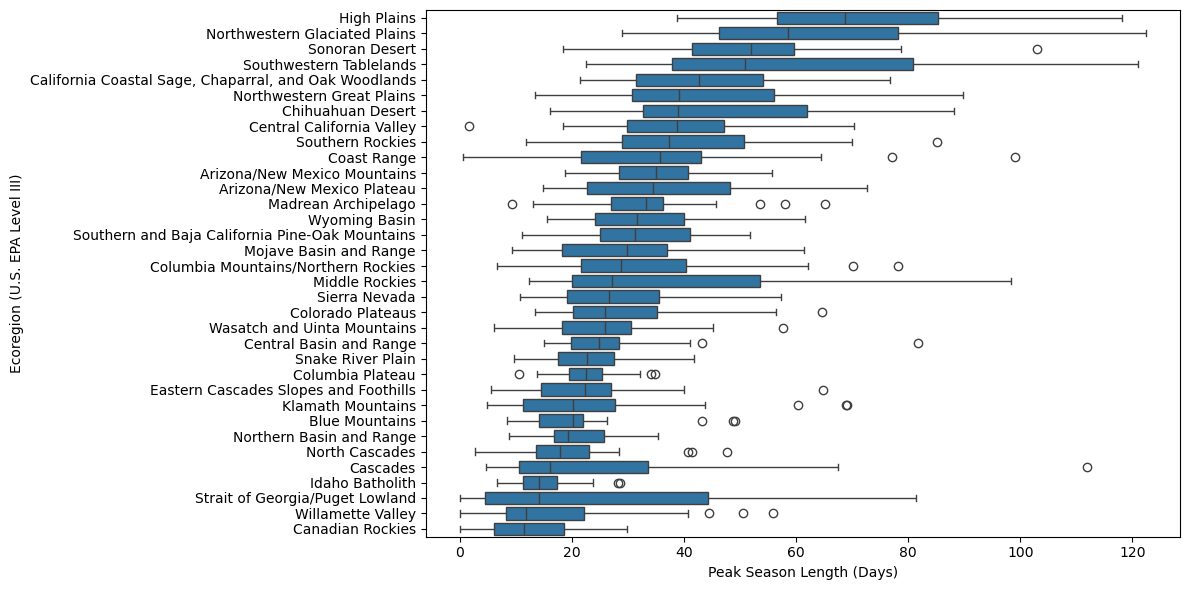

In [18]:
# Sort the ecoregions by season length or peak season DOY
order = fire_stats.groupby('na_l3name')['peak_season_length'].median().sort_values(ascending=False).index

# Plot the distribution of peak season stats by ecoregion
plt.figure(figsize=(12, 6))
sns.boxplot(y='na_l3name', x='peak_season_length', data=fire_stats, order=order)  
plt.xlabel('Peak Season Length (Days)')
plt.ylabel('Ecoregion (U.S. EPA Level III)')
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the ecoregion statistics, export as a CSV.

In [21]:
# Calculate median ecoregion stats
ecoregion_stats = fire_stats.groupby('na_l3name').agg(
    ig_doy_start=('discovery_doy_start','median'),
    last_doy_end=('containment_doy_end','median'),
    peak_season=('peak_season', 'median'),
    peak_season_length=('peak_season_length', 'median')
).reset_index()

ecoregion_stats.head()

,na_l3name,ig_doy_start,last_doy_end,peak_season,peak_season_length
0,Arizona/New Mexico Mountains,112.2,272.00,166.234057,34.908212
1,Arizona/New Mexico Plateau,72.0,232.80,177.402640,34.444520
2,Blue Mountains,183.6,279.80,220.294312,20.113712
3,"California Coastal Sage, Chaparral, and Oak Wo...",150.8,273.60,223.897545,42.732732
4,Canadian Rockies,209.1,306.55,223.703960,11.485212


In [22]:
ecoregion_stats[ecoregion_stats['na_l3name'] == 'Southern Rockies']

,na_l3name,ig_doy_start,last_doy_end,peak_season,peak_season_length
27,Southern Rockies,115.7,287.0,182.970031,37.373472


In [26]:
# Save the files out.
out_fp = os.path.join(results_dir, 'ecol3-west_fpa-fod_fire-season-length_annual.csv')
fire_stats.to_csv(out_fp)
print(f"Saved annual summary table to {out_fp}.")

print("\n~~~\n")

out_fp = os.path.join(results_dir, 'ecol3-west_fpa-fod_fire-season-length_agg.csv')
ecoregion_stats.to_csv(out_fp)
print(f"Saved ecoregion summary table to {out_fp}.")

Saved annual summary table to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/FPA-FOD/ecol3-west_fpa-fod_fire-season-length_annual.csv.

~~~

Saved ecoregion summary table to /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/tabular/mod/FPA-FOD/ecol3-west_fpa-fod_fire-season-length_agg.csv.


In [27]:
# Save the spatial data (managed wildfires)
out_dir = os.path.join(projdir,'data/spatial/mod/FPA-FOD/')
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
out_fp = os.path.join(out_dir,'fpa-fod_west_clean.gpkg')
fpa_fod_large.to_file(out_fp)
print(f"Saved FPA-FOD managed fires (>10 acres) to: {out_fp}")

Saved FPA-FOD managed fires (>10 acres) to: /Users/max/Library/CloudStorage/OneDrive-Personal/mcook/aspen-fire/Aim2/data/spatial/mod/FPA-FOD/fpa-fod_west_clean.gpkg
